In [1]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import cv2
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
from torchvision import transforms
from torch import nn
import torch
from torchvision import models
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import random
import numpy as np
from sklearn.neighbors import KernelDensity
from numpy import array
from torch import Tensor
from torchsummary import summary

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Github example

In [15]:
# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
        
resnet = torchvision.models.resnet18(pretrained=True)
resnet.eval()
model = ResnetFeatureExtractor(resnet)
summary(model.feature_extractor.to('cuda'), (3, 256, 256))
model = ResnetFeatureExtractor(resnet)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [16]:
def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [20]:
image, image_float, input_tensor = get_image_from_url("https://th.bing.com/th/id/R.c65135374de94dea2e2bf8fe0a4818e7?rik=Z75HF5uFr56PAw&pid=ImgRaw&r=0")

car_img, car_img_float, car_tensor = get_image_from_url("https://www.wallpapersin4k.org/wp-content/uploads/2017/04/Foreign-Cars-Wallpapers-4.jpg")
model.to('cpu')
car_concept_features = model(car_tensor)[0, :]
print(car_concept_features.shape)
print(car_concept_features)

torch.Size([512])
tensor([1.2790, 1.1211, 1.4021, 1.1935, 0.7436, 0.4900, 0.7108, 0.5803, 0.9319,
        0.8416, 0.2663, 0.3903, 0.2216, 0.3760, 0.2630, 0.3573, 0.4435, 0.9873,
        0.1452, 0.3751, 0.3242, 0.2801, 1.0793, 0.6750, 0.5562, 0.9802, 0.4189,
        0.9617, 0.2270, 0.1849, 0.4205, 0.3085, 1.3574, 0.4589, 0.2235, 0.1079,
        0.4696, 0.3943, 0.5828, 0.1717, 0.4649, 1.5523, 0.5984, 0.1273, 0.4482,
        1.0620, 0.6302, 0.5004, 0.4900, 0.1350, 0.0620, 0.0660, 0.4739, 0.1629,
        1.6472, 0.0502, 0.1717, 0.3076, 0.4573, 0.3166, 0.2143, 0.3500, 0.8021,
        0.7414, 0.2833, 0.4056, 0.2008, 0.2532, 0.4925, 0.5338, 0.5147, 0.2916,
        0.5427, 0.4950, 0.0566, 0.2628, 0.6904, 0.3512, 0.1619, 0.1563, 0.1858,
        0.9311, 1.5147, 0.1982, 0.1639, 1.0435, 0.1761, 0.1740, 0.6060, 0.5719,
        0.4357, 0.3748, 0.2790, 0.5359, 0.4638, 0.1650, 1.8989, 0.1217, 0.4209,
        0.9378, 0.2268, 0.7036, 0.9180, 0.9648, 0.6231, 0.4739, 1.1561, 1.2485,
        0.7093, 0.8558

In [33]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [resnet.layer4[-1]]
print(target_layers)
car_targets = [SimilarityToConceptTarget(car_concept_features)]

[BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


(1, 512, 512)


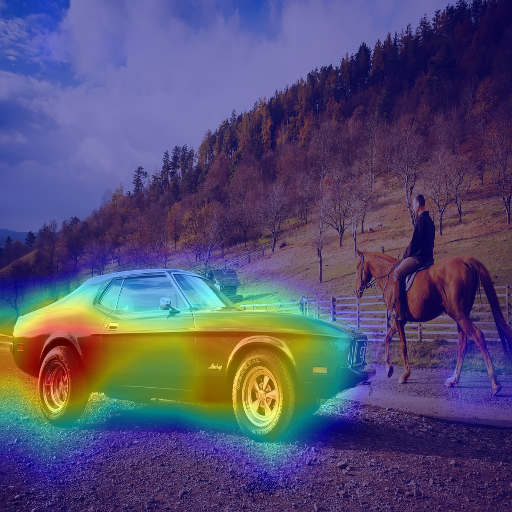

In [23]:
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)
    print(car_grayscale_cam.shape)
    car_grayscale_cam = car_grayscale_cam[0,:]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

# My Example

## Model def

In [21]:
class SSLModel(nn.Module):
    def __init__(self, 
                num_classes:int,
                seed:int=0,
                dims:array = [512,512,512,512,512,512,512,512,128]):
        
        super().__init__()
        self.seed = seed
        self.num_classes = num_classes
        self.localization = False

        self.feature_extractor = self.setup_feature_extractor()
        self.projection_head = self.setup_projection_head(dims)
        self.classifier = nn.Linear(128, self.num_classes)
        
        self.gradients = None
        random.seed(seed)
        np.random.seed(seed)
        torch.random.manual_seed(seed)

    
    def setup_projection_head(self, dims):
        proj_layers = []
        for d in dims[:-1]:
            proj_layers.append(nn.Linear(d,d, bias=False)),
            proj_layers.append((nn.BatchNorm1d(d))),
            proj_layers.append(nn.ReLU(inplace=True))
        embeds = nn.Linear(dims[-2], dims[-1], bias=self.num_classes > 0)
        proj_layers.append(embeds)
        
        projection_head = nn.Sequential(
            *proj_layers
        )
        return projection_head
    
    
    def setup_feature_extractor(self):
        fe = getattr(models, 'resnet18')(weights="IMAGENET1K_V1")
        last_layer= list(fe.named_modules())[-1][0].split('.')[0]
        setattr(fe, last_layer, nn.Identity())

        fe.eval()
        for param in fe.parameters():
            param.requires_grad = False

        fe.fc = nn.Identity()
        return fe
    
    
    def set_for_localization(self, p=True):
        for param in self.feature_extractor.parameters():
            param.requires_grad = p
        for param in self.projection_head.parameters():
            param.requires_grad = p
        self.localization = p
    
        
    def compute_features(self, x):
        x = x.float()
        x = self.feature_extractor.conv1(x)
        x = self.feature_extractor.bn1(x)
        x = self.feature_extractor.relu(x)
        x = self.feature_extractor.maxpool(x)

        l1 = self.feature_extractor.layer1(x)
        l2 = self.feature_extractor.layer2(l1)
        l3 = self.feature_extractor.layer3(l2)
        l4 = self.feature_extractor.layer4(l3)
    
        avg_pool = self.feature_extractor.avgpool(l4)
        
        return (avg_pool, l1, l2, l3, l4)


    def forward(self, x):
        x = x.float()
        features = self.feature_extractor(x)
        features = torch.flatten(features, 1)
        embeddings = self.projection_head(features)
        output = self.classifier(embeddings)
        if self.localization:
            return output
        return (output, embeddings)


class SSLM(pl.LightningModule):
    def __init__(
            self,
            classification_task:str='3-way',
            lr:float=0.001,
            seed:int=0):
        
        super(SSLM, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.classification_task = classification_task
        self.num_classes = 3 if classification_task== '3-way' else 2
        self.seed = seed

        random.seed(seed)
        np.random.seed(seed)
        torch.random.manual_seed(seed)
        
        self.model = SSLModel(self.num_classes)
        self.localization = False
    
    def set_for_localization(self, p=True):
        self.model.set_for_localization(p)
        self.localization = p
    
    
    def forward(self, x):
        if self.localization:
            output = self.model(x)
            return  output
        
        output, embeddings = self.model(x)
        return  output, embeddings
    
    
    def training_step(self, batch, batch_idx):    
        x, y = batch
        y_hat, _ = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)

        metrics = {"train_accuracy": acc, "train_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)

        metrics = {"val_accuracy": acc, "val_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)

        return metrics


    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        
        metrics = {"test_accuracy": acc, "test_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)
        
        return metrics


    def _shared_eval_step(self, batch, batch_idx):
        x,y = batch
        y_hat, _ = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        return loss, acc


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat, _ = self.model(x)
        return y_hat


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=0.9, weight_decay=0.00003)
        return optimizer

## Code

In [31]:
class MyResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(MyResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        y = self.feature_extractor(x)
        print(y.shape)
        return y
        
sslm = SSLM.load_from_checkpoint('/home/ubuntu/TesiAnomalyDetection/outputs/computations/bottle/generative_dataset/3-way/best_model.ckpt')
sslm.eval()
sslm.set_for_localization(True)
my_model = MyResnetFeatureExtractor(sslm.model)
#summary(my_model.feature_extractor.to('cuda'), (3, 256, 256))
#my_model = MyResnetFeatureExtractor(sslm.model.feature_extractor)

In [32]:
print(sslm.model.feature_extractor.layer4[-1])

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [33]:
class MySimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1-cos(model_output, self.features)

torch.Size([1, 128])
torch.Size([1, 128])


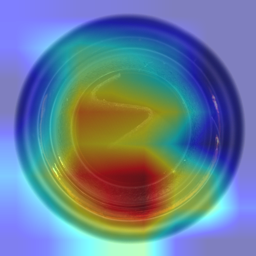

In [42]:
imsize = (256,256)
defect_type = 'good'
reference = Image.open('../dataset/bottle/test/'+defect_type+'/000.png').resize(imsize).convert('RGB')
x_ref = transforms.ToTensor()(reference)
x_ref = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(x_ref)

defect_type = 'contamination'
query_image = Image.open('../dataset/bottle/test/'+defect_type+'/015.png').resize(imsize).convert('RGB')

x_query = transforms.ToTensor()(query_image)
x_query = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(x_query)

my_model.to('cpu')
concept_features = my_model(x_ref[None, :])[0, :]
my_target_layers = [sslm.model.feature_extractor.layer4[-1]]
my_targets = [MySimilarityToConceptTarget(concept_features)]
with GradCAM(model=my_model,
             target_layers=my_target_layers,
             use_cuda=False) as cam1:

    grayscale_cam = cam1(input_tensor=x_query[None, :],
                        targets=my_targets)
    
my_grayscale_cam = grayscale_cam[0,:]

my_image_float = np.array(query_image)
my_image_float = np.float32(my_image_float) / 255
cam_image = show_cam_on_image(my_image_float, my_grayscale_cam, use_rgb=True)

Image.fromarray(cam_image) 

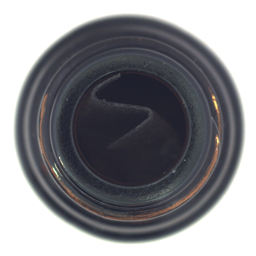

In [43]:
query_image